<a href="https://colab.research.google.com/github/KomissarYarrik/HMNNcourse2021/blob/main/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#подключаем кагл и загружаем данные
from google.colab import files
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c titanic

Saving kaggle.json to kaggle.json
  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 50.4MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 42.0MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 2.12MB/s]


In [2]:
#обрабатываем данные

#импорты
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from numpy.random import seed
from tensorflow.random import set_seed 

In [3]:
#нам понадобится заполнять пропуски. Так как они существуют и в тренировочных, и в тестовых данных, будет удобно временно объединить их

#загружаем данные как pandas dataframe
train = pd.read_csv('train.csv', )
test = pd.read_csv('test.csv')
df = pd.concat([train, test], axis=0, sort=True)

#в колонке Cabin больше тысячи пропущенных значений, нет смысла использовать ее
#заполнять будем колонки Age, Embarked и Fare

In [4]:
#мы имеем дело с блаародными серами, дамами и прочими господами и донами
#отделим приставки от имен в отдельный столбик
#это нужно для того, чтобы в дальнейшем заполнить пропуски в Age
df['Title'] = df['Name'].str.extract('([A-Za-z]+)\.', expand=True)

#большинство обнаруженных приставок это просто вариации из разных языков
#объединим их
mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr',
           'Don': 'Mr', 'Mme': 'Mrs', 'Jonkheer': 'Mr', 'Lady': 'Mrs',
           'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}
df.replace({'Title': mapping}, inplace=True)

#теперь мы можем найти средний медианный возраст носителя каждой приставки
title_ages = dict(df.groupby('Title')['Age'].median())
df['age_med'] = df['Title'].apply(lambda x: title_ages[x])
df['Age'].fillna(df['age_med'], inplace=True, )
del df['age_med']

#по аналогии заполним средним медианным значением Fare
class_fares = dict(df.groupby('Pclass')['Fare'].median())
df['fare_med'] = df['Pclass'].apply(lambda x: class_fares[x])
df['Fare'].fillna(df['fare_med'], inplace=True, )
del df['fare_med']

#в Embarked всего два пропущенных значения. Просто заменим их с помощью backfill
df['Embarked'].fillna(method='backfill', inplace=True)

#сохраняем данные
train = df[pd.notnull(df['Survived'])]
test = df[pd.isnull(df['Survived'])]
train.to_csv('train_clean.csv', index=False)
test.to_csv('test_clean.csv', index=False)

In [5]:
#обучаем сетку

#загружаем очищенные данные
train = pd.read_csv('train_clean.csv', )
test = pd.read_csv('test_clean.csv')
df = pd.concat([train, test], axis=0, sort=True)

In [6]:
#закодируем категориальные столбцы Embarked, Sex и Title, которые мы будем использовать в обучении
#Sex может быть представлен как 0 и 1, с остальными есть свои приколы
#остальные преобразуем как я не знаю это называется, снизу все покажу

df['Sex'] = df['Sex'].astype('category')
df['Sex'] = df['Sex'].cat.codes

categorical = ['Embarked', 'Title']
for var in categorical:
    df = pd.concat([df, 
                    pd.get_dummies(df[var], prefix=var)], axis=1)
    del df[var]

#выкидываем данные которые не будем использовать
df.drop(['Cabin', 'Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)
df.head()

,Age,Fare,Parch,Pclass,Sex,SibSp,Survived,Embarked_C,Embarked_Q,Embarked_S,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev
0,22.0,7.2500,0,3,1,1,0.0,0,0,1,0,0,0,1,0,0
1,38.0,71.2833,0,1,0,1,1.0,1,0,0,0,0,0,0,1,0
2,26.0,7.9250,0,3,0,0,1.0,0,0,1,0,0,1,0,0,0
3,35.0,53.1000,0,1,0,1,1.0,0,0,1,0,0,0,0,1,0
4,35.0,8.0500,0,3,1,0,0.0,0,0,1,0,0,0,1,0,0


In [7]:
#масштабируем переменные
continuous = ['Age', 'Fare', 'Parch', 'Pclass', 'SibSp']

scaler = StandardScaler()

for var in continuous:
    df[var] = df[var].astype('float64')
    df[var] = scaler.fit_transform(df[var].values.reshape(-1, 1))

df.head()

,Age,Fare,Parch,Pclass,Sex,SibSp,Survived,Embarked_C,Embarked_Q,Embarked_S,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev
0,-0.574635,-0.503176,-0.445,0.841916,1,0.481288,0.0,0,0,1,0,0,0,1,0,0
1,0.641140,0.734809,-0.445,-1.546098,0,0.481288,1.0,1,0,0,0,0,0,0,1,0
2,-0.270692,-0.490126,-0.445,0.841916,0,-0.479087,1.0,0,0,1,0,0,1,0,0,0
3,0.413182,0.383263,-0.445,-1.546098,0,0.481288,1.0,0,0,1,0,0,0,0,1,0
4,0.413182,-0.487709,-0.445,0.841916,1,-0.479087,0.0,0,0,1,0,0,0,1,0,0


In [8]:
#разбиваем датафрейм на тестовые и тренировочные данные
X_train = df[pd.notnull(df['Survived'])].drop(['Survived'], axis=1)
y_train = df[pd.notnull(df['Survived'])]['Survived']
X_test = df[pd.isnull(df['Survived'])].drop(['Survived'], axis=1)

In [9]:
#мутим модель на основе кросс-валидации
#используем очень простую архитектур: входной слой с 16 узлами, скрытый слой с 8 узлами и выходной слой

def create_model(lyrs=[8], act='linear', opt='Adam', dr=0.0):
    
    #устанавливаем рандомный сид
    seed(42)
    set_seed(42)
    
    model = Sequential()
    
    #первый скрытый слой
    model.add(Dense(lyrs[0], input_dim=X_train.shape[1], activation=act))
    
    #дополнительные скрытые слои
    for i in range(1,len(lyrs)):
        model.add(Dense(lyrs[i], activation=act))
    
    #дропаут
    model.add(Dropout(dr))
    
    #выходной слой
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [10]:
model = create_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 128       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 137
Trainable params: 137
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
#тренируем модель
#тренируем на полном тренировочном сете с разделением 80/20
training = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
val_accuracy = np.mean(training.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_accuracy', val_accuracy*100))


val_accuracy: 85.47%


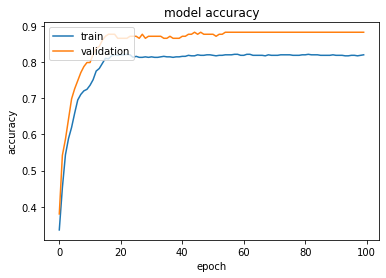

In [12]:
#красивый график

import matplotlib.pyplot as plt

plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()